In [2]:
import string
from pickle import load
from pickle import dump
from numpy import array
from numpy.random import shuffle
from numpy import argmax

# import Keras functions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from attention import Attention

# import BLEU calculator from NLTK
from nltk.translate.bleu_score import corpus_bleu

# Preprocess data

In [3]:
# Get data
with open('fra.txt', 'r', encoding='utf-8') as f:
    fra_dataset = f.read()
    
with open('pol.txt', 'r', encoding='utf-8') as f:
    pol_dataset = f.read()
    
# lower
fra_dataset = fra_dataset.lower()
pol_dataset = pol_dataset.lower()

# Split samples
fra_lines = fra_dataset.strip().split('\n')
fra_data = [i.split('\t')[:2] for i in fra_lines]

pol_lines = pol_dataset.strip().split('\n')
pol_data = [i.split('\t')[:2] for i in pol_lines]

# Remove punctuation
def remove_punct(sentence):
    for punct in string.punctuation:
        sentence = sentence.replace(punct, '')
    return sentence

for i in fra_data:
    i[0] = remove_punct(i[0])
    i[1] = remove_punct(i[1])
    
for i in pol_data:
    i[0] = remove_punct(i[0])
    i[1] = remove_punct(i[1])

In [4]:
# Shuffle data
shuffle(fra_data)
fra_splitpoint = len(fra_data) // 10
fra_train_data = fra_data[:-fra_splitpoint]
fra_test_data = fra_data[-fra_splitpoint:]

shuffle(pol_data)
pol_splitpoint = len(pol_data) // 10
pol_train_data = pol_data[:-pol_splitpoint]
pol_test_data = pol_data[-pol_splitpoint:]

# Save data
dump(fra_data, open('fra_data.txt', 'wb'))
dump(fra_train_data, open('fra_train_data.txt', 'wb'))
dump(fra_test_data, open('fra_test_data.txt', 'wb'))

dump(pol_data, open('pol_data.txt', 'wb'))
dump(pol_train_data, open('pol_train_data.txt', 'wb'))
dump(pol_test_data, open('pol_test_data.txt', 'wb'))

# Train eng2fra

In [5]:
# Load data
fra_data = load(open('fra_data.txt', 'rb'))
fra_train_data = load(open('fra_train_data.txt', 'rb'))
fra_test_data = load(open('fra_test_data.txt', 'rb'))

fra_data = array(fra_data)
fra_train_data = array(fra_train_data)
fra_test_data = array(fra_test_data)

In [6]:
# fit a tokenizer
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(fra_data[:, 0])

fra_tokenizer = Tokenizer()
fra_tokenizer.fit_on_texts(fra_data[:, 1])

eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1

In [7]:
print(max(len(i.split()) for i in fra_data[:, 0]))
print(max(len(i.split()) for i in fra_data[:, 1]))

47
55


In [8]:
# set sentence length
eng_length = 47
fra_length = 55

In [9]:
# encode and pad sequences
trainX = eng_tokenizer.texts_to_sequences(fra_train_data[:, 0])
trainX = pad_sequences(trainX, maxlen= eng_length, padding='post')

testX = eng_tokenizer.texts_to_sequences(fra_test_data[:, 0])
testX = pad_sequences(testX, maxlen= eng_length, padding='post')

trainY = fra_tokenizer.texts_to_sequences(fra_train_data[:, 1])
trainY = pad_sequences(trainY, maxlen= fra_length, padding='post')

testY = fra_tokenizer.texts_to_sequences(fra_test_data[:, 1])
testY = pad_sequences(testY, maxlen= fra_length, padding='post')

In [10]:
# define the encoder-decoder model
n_units = 64
embedding_size = 200

# encoder
eng_input = Input(shape=(eng_length, ), dtype='float32')
embedding = Embedding(eng_vocab_size, embedding_size, input_length=eng_length)(eng_input)
encoder_gru = Bidirectional(GRU(n_units*2, return_sequences=True, dropout=0.2))(embedding)
encoder_att = Attention()(encoder_gru)
# decoder
repeat = RepeatVector(fra_length)(encoder_att)
decoder_gru = Bidirectional(GRU(n_units*2, return_sequences=True, dropout=0.2))(repeat)
fra_output = TimeDistributed(Dense(fra_vocab_size, activation='softmax'))(decoder_gru)
model = Model(eng_input, fra_output)

# create a german to english translation model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# summarise the model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 47)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 47, 200)      3126200     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 47, 256)      253440      embedding[0][0]                  
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 256)          0           bidirectional[0][0]              
______________________________________________________________________________________________

In [ ]:
# because training takes time, we checkpoint the model during training
# this saves the partially trained model any time that the validation loss is reduced
filename = 'model_trans.h5'
checkpoint = ModelCheckpoint(filename, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')

history = model.fit(trainX, trainY, epochs = 100, batch_size = 256, validation_data = (testX, testY), callbacks = [checkpoint], verbose = 2)
del model

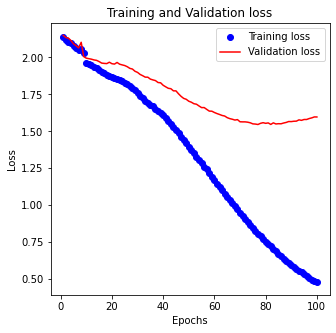

In [134]:
# get the history dictionary 
hist=history.history
epochs=range(1,len(hist['loss'])+1)

import matplotlib.pyplot as plt
%matplotlib inline

# plot loss curves
plt.figure(figsize=(5,5))
plt.plot(epochs,hist['loss'],'bo',label="Training loss")
plt.plot(epochs,hist['val_loss'],'r-',label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Train eng2pol
freeze the encoder of eng2fra

In [ ]:
# Load data
pol_data = load(open('pol_data.txt', 'rb'))
pol_train_data = load(open('pol_train_data.txt', 'rb'))
pol_test_data = load(open('pol_test_data.txt', 'rb'))

pol_data = array(pol_data)
pol_train_data = array(pol_train_data)
pol_test_data = array(pol_test_data)

In [ ]:
# fit a tokenizer
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(pol_data[:, 0])

pol_tokenizer = Tokenizer()
pol_tokenizer.fit_on_texts(pol_data[:, 1])

eng_vocab_size = len(eng_tokenizer.word_index) + 1
pol_vocab_size = len(pol_tokenizer.word_index) + 1

In [ ]:
print(max(len(i.split()) for i in pol_data[:, 0]))
print(max(len(i.split()) for i in pol_data[:, 1]))

In [ ]:
# set sentence length
eng_length = 47
pol_length = 38

In [ ]:
# encode and pad sequences
trainX = eng_tokenizer.texts_to_sequences(pol_train_data[:, 0])
trainX = pad_sequences(trainX, maxlen= eng_length, padding='post')

testX = eng_tokenizer.texts_to_sequences(pol_test_data[:, 0])
testX = pad_sequences(testX, maxlen= eng_length, padding='post')

trainY = pol_tokenizer.texts_to_sequences(pol_train_data[:, 1])
trainY = pad_sequences(trainY, maxlen= pol_length, padding='post')

testY = pol_tokenizer.texts_to_sequences(pol_test_data[:, 1])
testY = pad_sequences(testY, maxlen= pol_length, padding='post')

In [ ]:
# define the encoder-decoder model
n_units = 64
embedding_size = 200

# encoder
eng_input = Input(shape=(eng_length, ), dtype='float32')
embedding = Embedding(eng_vocab_size, embedding_size, input_length=eng_length, trainable=False)(eng_input)
encoder_gru = Bidirectional(GRU(n_units*2, return_sequences=True, dropout=0.2, trainable=False))(embedding)
encoder_att = Attention()(encoder_gru)
# decoder
repeat = RepeatVector(fra_length)(encoder_att)
decoder_gru = Bidirectional(GRU(n_units*2, return_sequences=True, dropout=0.2))(repeat)
fra_output = TimeDistributed(Dense(fra_vocab_size, activation='softmax'))(decoder_gru)
model = Model(eng_input, fra_output)

# create a german to english translation model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# summarise the model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.load_weights('model_trans.h5')

filename = 'model_trans_2.h5'
checkpoint = ModelCheckpoint(filename, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')

history = model.fit(trainX, trainY, epochs = 100, batch_size = 256, validation_data = (testX, testY), callbacks = [checkpoint], verbose = 2)
del model

In [ ]:
# get the history dictionary 
hist=history.history
epochs=range(1,len(hist['loss'])+1)

import matplotlib.pyplot as plt
%matplotlib inline

# plot loss curves
plt.figure(figsize=(5,5))
plt.plot(epochs,hist['loss'],'bo',label="Training loss")
plt.plot(epochs,hist['val_loss'],'r-',label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Predict

In [136]:
# load model
model = load_model('model_trans_2.h5')

# evaluate the performance of the model
actual = []
predicted = []
for i, sample in enumerate(testX):
    sample = sample.reshape((1, sample.shape[0]))
    prediction = model.predict(sample, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = []
    for j in integers:
        for w, index in pol_tokenizer.word_index.items():
            word = w if index == j else None
        if word is None:
            break
        target.append(word)
    translation = ' '.join(target)
    
    if i < 10:
        print('src=[%s], target=[%s], predicted=[%s]' % (pol_test_data[i][0], pol_test_data[i][1], translation))
        
    actual.append([pol_test_data[i][1].split()])
    predicted.append(translation.split())
    
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))